### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In this notebook, we consider an imbalanced dataset of credit card frauds (with the target labels being authentic and fraudulent) and build an anomaly detection system to identify transactions that are, in some sense, different from the usual, authentic transactions. These observations are flagged as potentially fraudulent and put to further verification.

### 1. Import libraries

In [1]:
# file system management librariy
import time 
# library for mathmatical functions
import math

# data mainpulation
import pandas as pd
import numpy as np

# ploting and visualization
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Train_Test_Split
from sklearn.model_selection import train_test_split
from tqdm.contrib import itertools

# evalutation libraties
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#### Anomaly Detection¶
In statistics and data analysis, an anomaly or outlier refers to a rare observation which deviates significantly from the majority of the data and does not conform to a well-defined notion of normal behaviour. It is possible that such observations may have been generated by a different mechanism or appear inconsistent with the remainder of the dataset. The process of identifying such observations is generally referred to as anomaly detection. In recent days, machine learning is progressively being employed to automate the process of anomaly detection through supervised learning (when observations are labeled as normal or anomalous), semi-supervised learning (when only a small fraction of observations are labeled) and unsupervised learning (when observations are not labeled). Anomaly detection is particularly suitable in the following setup:

Anomalies are very rare in the dataset
The features of anomalous observations differ significantly from those of normal observations
Anomalies may result for different (potentially new) reasons
Anomaly detection can be very useful in credit card fraud detection. Fraudulent transactions are rare compared to authentic transactions. Also, the methods through which fraudulent transactions occur keep evolving, as the old ways get flagged by existing fraud detection systems. In this notebook, we shall develop a basic anomaly detection system that flags transactions with feature values deviating significantly from those of authentic transactions.

### 2. Load Data

In [2]:
data = pd.read_csv('creditcard.csv.zip')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


### Project Objective
The objective of the project is to detect anomalies in credit card transactions. To be prcise, given the data on Time, Amount and transformed features V1 to V28, our goal is to fit a probability distribution based on authentic transactions, and then use it to correctly identify a new transaction as authentic or fraudulent. Note that the target variable plays no role in constructing the probability distribution.

### Evaluation Metric
Any prediction about a binary categorical target variable falls into one of the four categories:

- True Positive: The classification model correctly predicts the output to be positive
- True Negative: The classification model correctly predicts the output to be negative
- False Positive: The classification model incorrectly predicts the output to be positive
- False Negative: The classification model incorrectly predicts the output to be negative

Let TP, TN, FP and FN respectively denote the number of true positives, true negatives, false positives and false negatives among the predictions made by a particular classification model. Below we give the definitions of some evaluation metrics based on these four quantities.

1. Accuracy=Number of correct predictions / Number of total predictions=TP+TNTP+TN+FP+FN
2. Precision=Number of true positive predictions / Number of total positive predictions=TPTP+FP
3. Recall=Number of true positive predictions / Number of total positive cases=TPTP+F N
4. Fowlkes-Mallows index (FM)=Geometric mean of Precision and Recall= squar root of (Precision×Recall)
5. F1-Score=Harmonic mean of Precision and Recall=2×Precision×Recall / Precision+Recall
6. Fβ-score=(1+β2)×Precision×Recall / (β2×Precision)+Recall=(1+β2)×TP(1+β2)×TP+β2×FN+FP,
where β
 is a positive factor, chosen such that Recall is β
 times as important as Precision in the analysis. Popular choices of β
 are 0.5
, 1
 and 2
.

Matthews Correlation Coefficient (MCC)=(TP×TN)−(FP×FN)/ square root ((TP+FP)×(TP+FN)×(TN+FP)×(TN+FN))


Unlike the previous metrics, MCC varies from −1
 (worst case scenario) to 1
 (best case scenario: perfect prediction). Among the discussed metrics, some good choices to evaluate models, in particular for imbalanced datasets, are MCC and F1
-score, while Precision and Recall also give useful information. We shall not give much importance to the Accuracy metric in this project as it produces misleading conclusions when the classes are not balanced. In the problem at hand, false negative (a fraudulent transaction being classified as authentic) is more dangerous than false positive (an authentic transaction being classified as fraudulent). In the former case, the fraudster can cause further financial damage. In the latter case, the bank can cross-verify the authenticity of the transaction from the card-user after taking necessary steps to secure the card. Considering this fact, we employ F2
-score to tune threshold parameter and to select features in the present work. In terms of TP, TN, FP, and FN, it is given by

F2-score=5×TP5×TP+4×FN+FP.
All of the mentioned metrics are reported for both the validation set and the test set.

### 3. Spliting Data Train_Validatin_Test split

In [4]:
# Splitting the data by target class
data_0, data_1 = data[data['Class'] == 0], data[data['Class'] == 1]

# Feature-target split
X_0, y_0 = data_0.drop('Class', axis = 1), data_0['Class']
X_1, y_1 = data_1.drop('Class', axis = 1), data_1['Class']

# Splitting the authentic class and constructing the training set
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, test_size = 0.2, random_state = 40)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val_1, data_test_1 = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Splitting the fraudulent class
X_val, X_test, y_val, y_test = train_test_split(X_1, y_1, test_size = 0.5, random_state = 40)
data_val_2, data_test_2 = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Merging data to construct the validation set and the test set
data_val, data_test = pd.concat([data_val_1, data_val_2], axis = 0), pd.concat([data_test_1, data_test_2], axis = 0)
X_val, y_val = data_val.drop('Class', axis = 1), data_val['Class']
X_test, y_test = data_test.drop('Class', axis = 1), data_test['Class']

In [5]:
len(y_train[y_train==1])

0

In [6]:
# distribution of athuntic and fruad transaction over Traing ,validation and Test
labels =['Train',"Validation","Test"]
values_0 =[len(y_train[y_train==0]),len(y_val[y_val==0]),len(y_test[y_test==0])]
values_1 =[len(y_train[y_train==1]),len(y_val[y_val==1]),len(y_test[y_test==1])]

fig = make_subplots(rows=1 ,cols=2,specs = [[{'type': 'domain'}, {'type': 'domain'}]]) # {'type': 'domain'}: This dictionary defines the subplot type as 'domain'. 
fig.add_trace(go.Pie(values =values_0,labels= labels,hole= 0.5,textinfo='percent',title ="Authntic"),row=1,col=1) # This means each subplot will occupy the entire area 
fig.add_trace(go.Pie(values =values_1,labels= labels,hole= 0.5,textinfo='percent',title ="Fruad"),row=1,col=2) # allocated to it within the row and column layout.

text_title = "Distribution of authentic and fraudulent transactions over training, validation and test set"

fig.update_layout(height = 500 ,width = 800 ,showlegend= True ,title =dict(text = text_title))

fig.show()

we choose the number of bins of a histogram by the Freedman-Diaconis rule, which suggests the optimal number of bins to grow as  k∼n1/3, where  n is the total number of observations.

In [7]:
# setting number of bins
bins_train = math.floor(len(X_train)**(1/3))

### 4.Feature Engineering
Time

In [8]:
# Decomposing Time 
for df in [X_train,X_val,X_test]:
    df['day'],remider = df['Time'] // (24*60*60) ,df['Time'] % (24*60*60)
    df['Hour'],remider = df['Time'] // (60*60) ,df['Time'] % (60*60)
    df['Minute'],df['second'] = df['Time'] // (60) ,df['Time'] % (60)

X_train[['Time','day','Hour',"Minute","second"]].head()

,Time,day,Hour,Minute,second
19594,30401.0,0.0,8.0,506.0,41.0
124712,77397.0,0.0,21.0,1289.0,57.0
167920,118964.0,1.0,33.0,1982.0,44.0
47377,43191.0,0.0,11.0,719.0,51.0
41731,40804.0,0.0,11.0,680.0,4.0


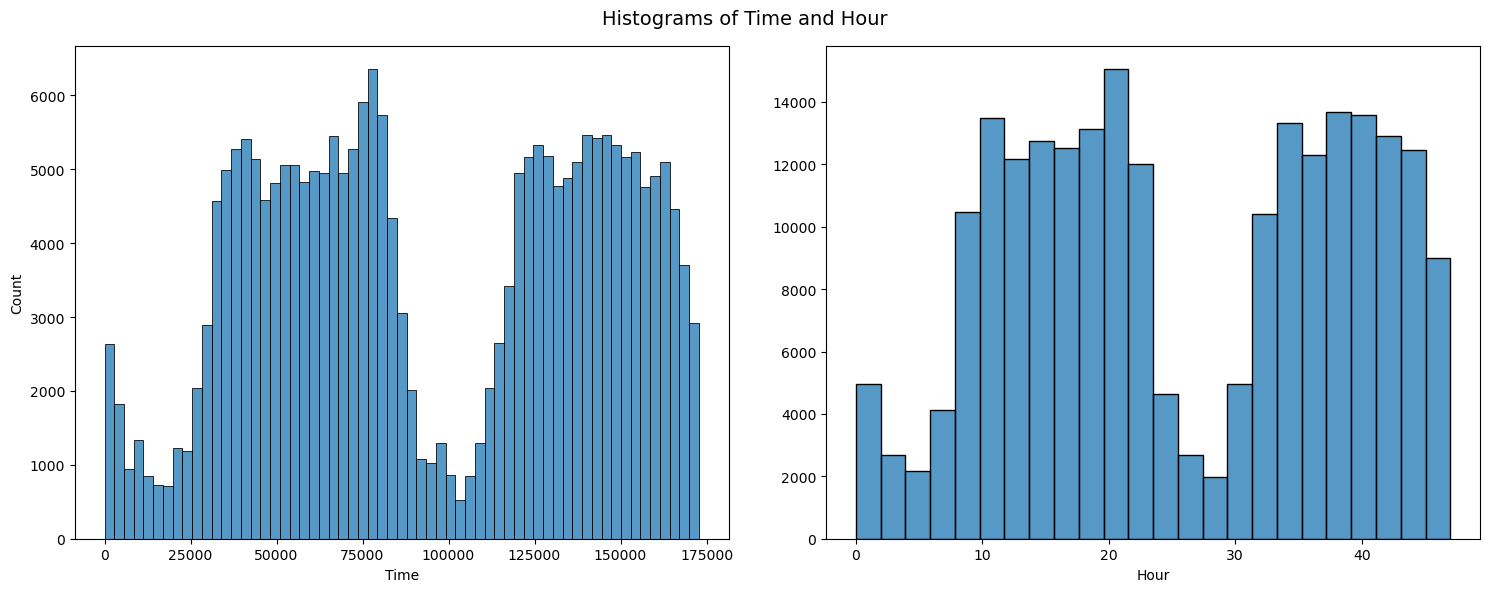

In [9]:
 
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(data = X_train, x = 'Time', bins = bins_train, ax = ax[0])
sns.histplot(data = X_train, x = 'Hour', bins = 24, ax = ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Time and Hour", size = 14)
plt.tight_layout()
plt.show()

### Amount

<Axes: xlabel='Amount', ylabel='Count'>

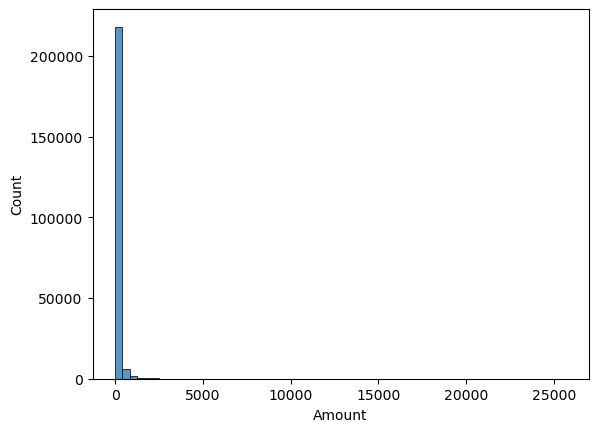

In [10]:
# see distribution of Amount
sns.histplot(X_train['Amount'],bins=bins_train)

The distribution of Amount has extreme positive skewness. We apply the transformation  x↦log(x+0.001)
  to this column and form the new column Amount_transformed. The positive constant  0.001
  is added to deal with the zero-amount transactions, which leads to  log0
 , an undefined quantity

In [11]:
for df in [X_train,X_val,X_test]:
    df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)


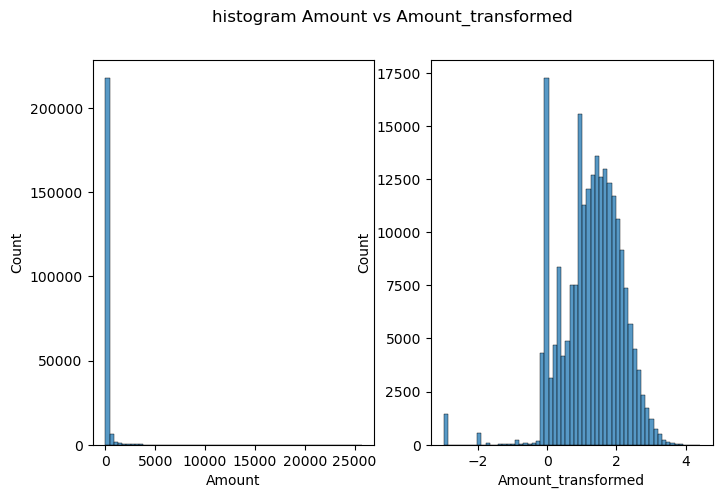

In [12]:
# visualization of Amount vs Amount transformed
fig,ax =plt.subplots(1,2,figsize=(8,5))
sns.histplot(data = X_train,x=X_train['Amount'],bins=bins_train,ax=ax[0])
sns.histplot(data = X_train,x=X_train['Amount_transformed'],bins=bins_train,ax=ax[1])
plt.suptitle("histogram Amount vs Amount_transformed")
plt.show()

In [13]:
# Descaring unnecessary columns
for df in [X_train,X_val,X_test]:
    df.drop(['Time','Amount','day','second','Minute'],axis=1,inplace=True)


### 5. Feature Selection

In the problem at hand, we have  30
  features. We aim to keep only those which help substantially in discriminating between authentic and fraudulent transactions. More specifically, we compare the distribution of each feature for both the target classes. If a feature has similar distributions for both authentic and fraudulent transactions, then it is not likely to contribute much in the process of classifying a transaction as authentic or fraudulent. However, if a feature has very different distributions for different target classes, then it plays a far more significant role in the same process. We plot the distributions and select the features exhibiting fairly distinct distributions across the target classes

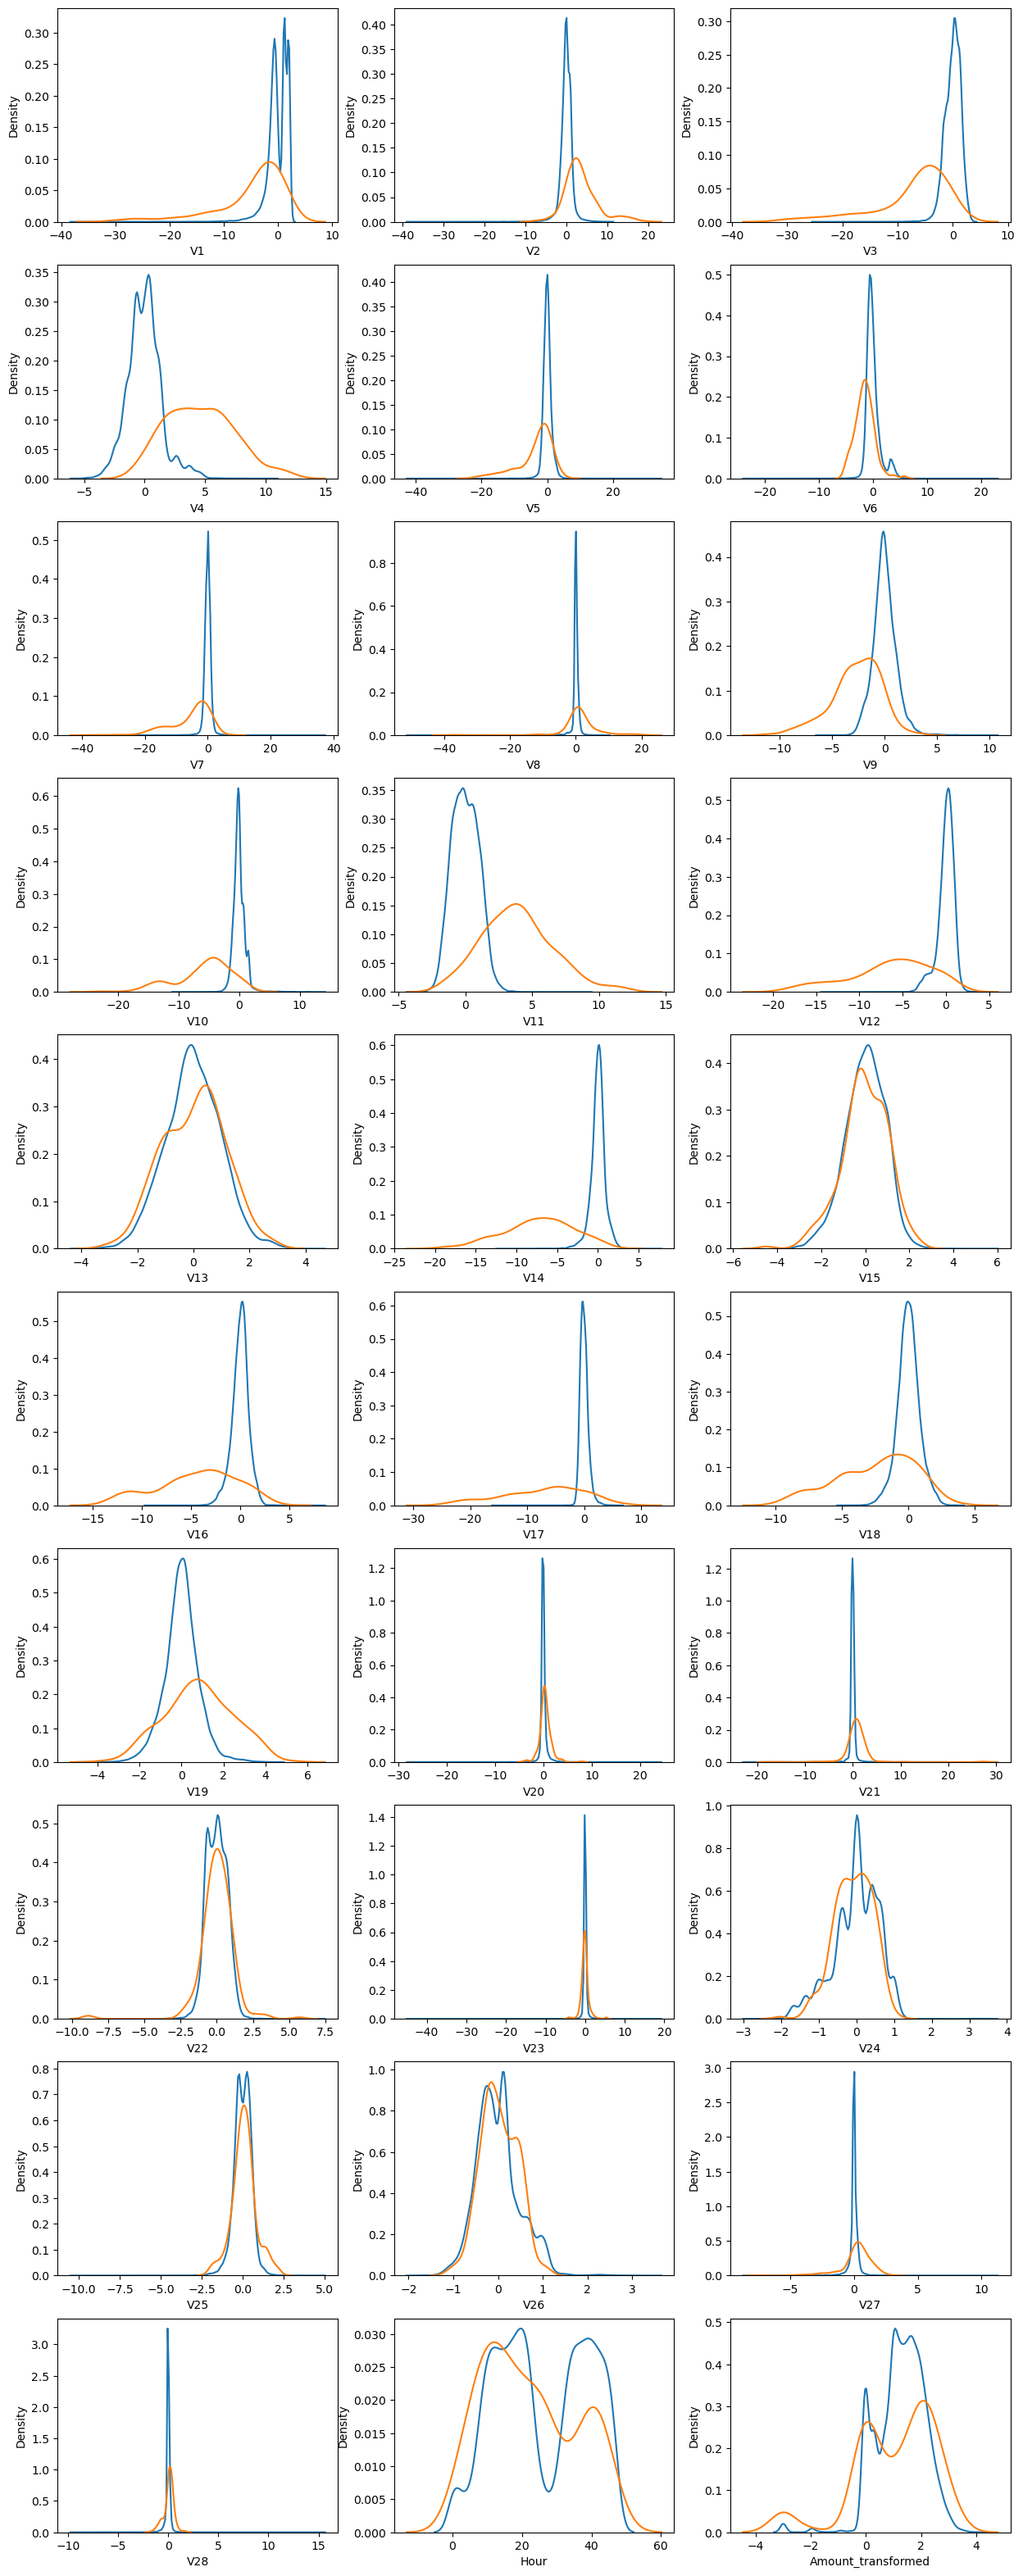

In [14]:
# Comparasion of feature distributions for different target classes
data_validation = pd.concat([X_val,y_val],axis=1)
value_0,value_1 = data_validation[data_validation['Class']==0],data_validation[data_validation['Class']==1]
cols =list(X_val.columns)
num_cols_plot = 3 
num_rows_plot = math.ceil(len(cols)/num_cols_plot)


fig,ax = plt.subplots(num_rows_plot,num_cols_plot,figsize = (15,40))

for i in range(len(cols)):
  sns.kdeplot(value_0[cols[i]],ax = ax[i // num_cols_plot,i % num_cols_plot]) # i // num_cols --> gives row index as int
  sns.kdeplot(value_1[cols[i]],ax = ax[i // num_cols_plot,i % num_cols_plot]) # i % num_cols --> gives column index

plt.show()



In [15]:
# Feature selection
cols = ['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour']
X_train_fs, X_val_fs, X_test_fs = X_train[cols], X_val[cols], X_test[cols]
X_train_fs.head()

,V4,V11,V12,V14,V16,V17,V18,V19,Hour
19594,-0.706232,2.027925,0.535822,0.250769,0.773615,0.449717,-1.963208,0.613481,8.0
124712,1.474933,-1.154523,0.263527,0.316174,-1.029415,1.030772,-0.438839,0.529080,21.0
167920,4.840766,-2.242431,0.034829,-0.546349,-0.070375,1.033695,0.531801,1.215045,33.0
47377,0.565273,-0.157045,-0.548790,0.419194,0.183518,-0.681323,0.911357,1.318132,11.0
41731,-0.428860,-0.580964,-0.609099,-0.187948,1.226723,0.104368,-0.995711,0.420557,11.0


### 6. Implementing Anomaly Detection

The probability density function (pdf) of a univariate normal distribution with mean  μ
  and standard deviation  σ
  is given by
  
f(x; μ, σ) = (1 / (σ * sqrt(2π))) * exp(-(x - μ)^2 / (2 * σ^2))

In [17]:
# normal probability density function of univariate 
def normal_density(x,mu,sigma):
    assert sigma > 0, "Standard deviation must be positive"
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)

    return f

The next function computes the product of such univariate normal densities. This can be seen as the joint pdf of a number of feature variables, each of which has a univariate normal distribution and is statistically independent of the other features.

g(x;μ,σ)= ∏i f(xi;μi,σi)

In [18]:
def normal_product(x_vec,mu_vec,sigma_vec):
    
    assert min(sigma_vec) > 0, "Standard deviation must be positive"
    assert len(mu_vec) == len(x_vec), "Length of mean vector does not match length of input vector"
    assert len(sigma_vec) == len(x_vec), "Length of standard deviation vector does not match length of input vector"
    f = 1
    for i in range(len(x_vec)):
        f = f * normal_density(x_vec[i], mu_vec[i], sigma_vec[i])

    return f


Next, we compute the vector of means and vector of standard deviations for the features in the training set. These estimates characterize the joint probability density function of the features, which will be used to detect anomalous observations.

U_train = (μ1_train,μ2_train,⋯,μn_train),

where μi_train= (1/ m ) *∑j x(j)i_train, fori=1,2,⋯,n

σ_train=(σ1_train,σ2_train,⋯,σn_train) ,where

σ_train = np.sqrt( (1/m )* ∑ (x(i)_train) - u(i)_train)

In [19]:
mu_train ,sigma_train = X_train_fs.mean().values,X_train_fs.std().values

In [20]:
sigma_train

array([ 1.39904453,  1.003834  ,  0.94686759,  0.89827266,  0.84445907,
        0.75115106,  0.82436083,  0.81236725, 13.18624779])

Then, we predict anomaly based on a given threshold  ϵ
for probability density in the following way:

- y=0(not anomaly) , if  g(x;μtrain,σtrain) ≥ϵ,
- y=1(anomaly) 

In [21]:
# function to predict anomaly based on probability density threshold
def model_normal(x,epsilon):
    y =[]   # y --> result if anomaly or normal transaction
    for i in x.index:
        prob_dinsty = normal_product(x.loc[i].tolist(),mu_train,sigma_train)
        y.append((prob_dinsty<epsilon).astype(int))

    return y

### 7. Threshold Tuning on Validation Set

In [22]:
alpha_list, f2_list, f2_max, alpha_opt, y_val_pred_opt = [], [], 0.0, 0.0, np.zeros(len(y_val))
for alpha, j in itertools.product(np.arange(0.001, 0.051, 0.001), range(1)):
    y_val_pred = model_normal(X_val_fs, epsilon = alpha**X_val_fs.shape[1])
    f2 = fbeta_score(y_val, y_val_pred,beta=2)
    alpha_list.append(alpha)
    f2_list.append(f2)
    if f2 > f2_max:
        alpha_opt = alpha
        y_val_pred_opt = y_val_pred
        f2_max = f2
 


  0%|          | 0/50 [00:00<?, ?it/s]

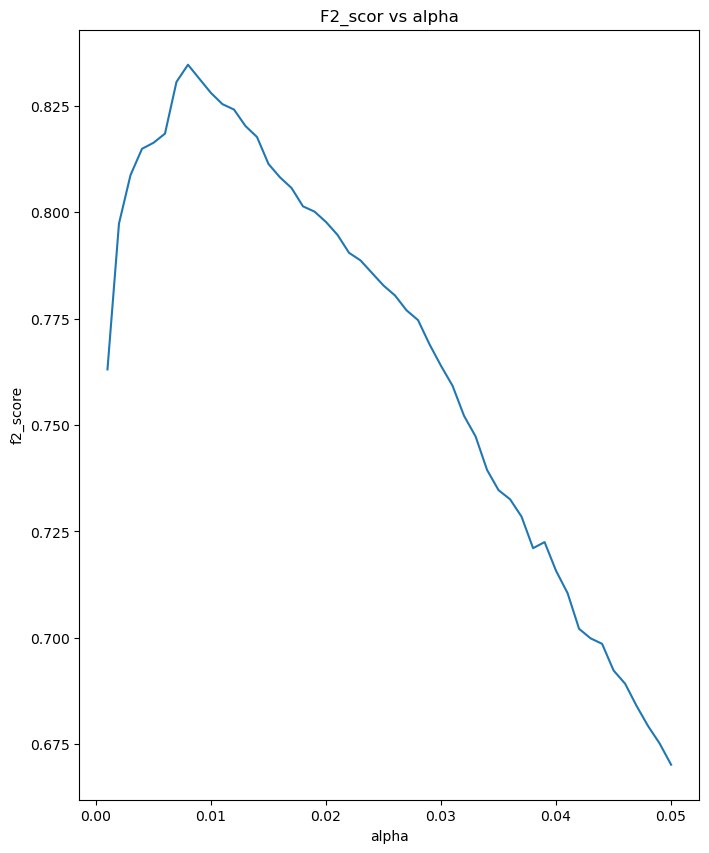

In [23]:
# ploting f2_score vs alpha 
plt.figure(figsize=(8,10))
plt.plot(alpha_list,f2_list)
plt.xlabel("alpha")
plt.ylabel('f2_score')
plt.title('F2_scor vs alpha')
plt.show()

# plt.tight_layout() is a function used to automatically adjust
# the spacing around subplots in
# a figure to prevent overlapping elements and improve the overall layout.

In [24]:
# print optimal values
print(f"Optimal alpha : {alpha_opt}\nOptimal f2_score : {fbeta_score(y_val,y_val_pred_opt,beta=2)}")

Optimal alpha : 0.008
Optimal f2_score : 0.8346709470304976


### Prediction and Evaluation on Test Set

In [25]:
y_test_normal = model_normal(X_test_fs,epsilon=alpha_opt**X_test_fs.shape[1])
print(fbeta_score(y_test,y_test_normal,beta=2))

0.8097165991902834


### Conclusion
To sum up, we observed that the data is heavily imbalanced with fraudulent transaction occurring rarely compared to authentic transactions. Also there are possibilities for fraudulent transactions to occur in completely new ways than before, making it difficult to train data on fraudulent transactions. Thus we build an anomaly detection system to find transactions, which are, in some sense, different from the usual observations.

Specifically, we have extracted Hour out of the Time feature and log-transformed (with a slight shift) the highly skewed Amount feature into Amount_transformed. Out of the 
30
 features (obtained after feature engineering), we have selected 
9
 features which have significantly different distributions, for the different target classes: V4, V11, V12, V14, V16, V17, V18, V19 and Hour. Based on the training data, we fit a multivariate normal distribution (by estimating the vector of means and the vector of standard deviations, assuming statistical independence among the features, which is a reasonable condition as most of the features in the provided dataset are already PCA-engineered). Given a new transaction, if the corresponding density value of the fitted distribution is lower than a pre-specified threshold, then we flag the transaction as fraudulent. The choice of the threshold is optimized by iterating over a pre-specified set of values, predicting on the validation set, and evaluating the estimates by means of the 
F
2
-score.

In this work, the optimal threshold value comes out to be 
0.009
9
≈
3.87
×
10
−
19
. The corresponding 
F
2
-score for predictions on the validation set is 
0.834671
, which is an optimistic projection due to the threshold tuning over the validation set. Applying the same model on the test set, we get predictions with an 
F
2
-score of 
0.816492
.Conclusion¶
To sum up, we observed that the data is heavily imbalanced with fraudulent transaction occurring rarely compared to authentic transactions. Also there are possibilities for fraudulent transactions to occur in completely new ways than before, making it difficult to train data on fraudulent transactions. Thus we build an anomaly detection system to find transactions, which are, in some sense, different from the usual observations.

Specifically, we have extracted Hour out of the Time feature and log-transformed (with a slight shift) the highly skewed Amount feature into Amount_transformed. Out of the 
30
 features (obtained after feature engineering), we have selected 
9
 features which have significantly different distributions, for the different target classes: V4, V11, V12, V14, V16, V17, V18, V19 and Hour. Based on the training data, we fit a multivariate normal distribution (by estimating the vector of means and the vector of standard deviations, assuming statistical independence among the features, which is a reasonable condition as most of the features in the provided dataset are already PCA-engineered). Given a new transaction, if the corresponding density value of the fitted distribution is lower than a pre-specified threshold, then we flag the transaction as fraudulent. The choice of the threshold is optimized by iterating over a pre-specified set of values, predicting on the validation set, and evaluating the estimates by means of the 
F2-score.

In this work, the optimal threshold value comes out to be 
0.008
 
. The corresponding 
F
2
-score for predictions on the validation set is 
0.834671  
, which is an optimistic projection due to the threshold tuning over the validation set. Applying the same model on the test set, we get predictions with an 
F2
-score of 
0.80971
